결과 데이터가 CSV 파일로 저장되었습니다.


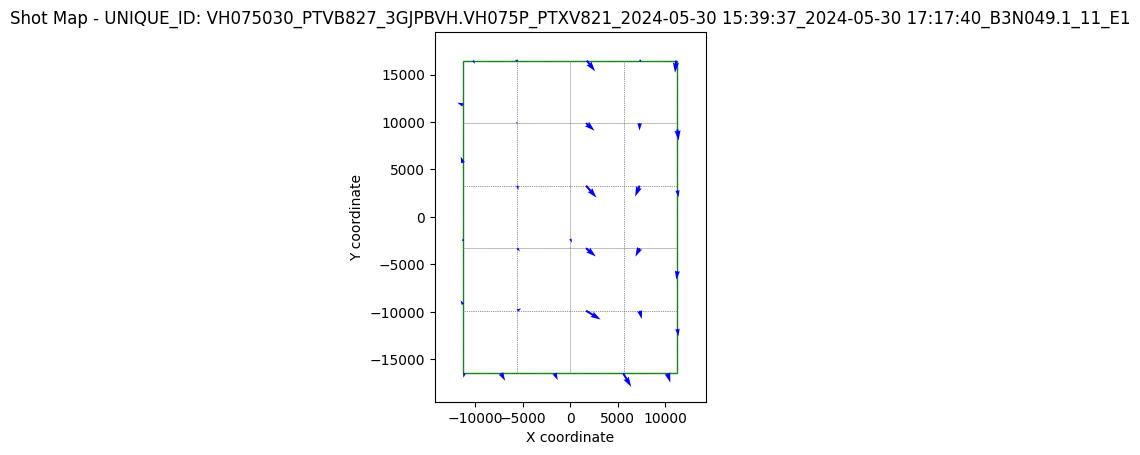

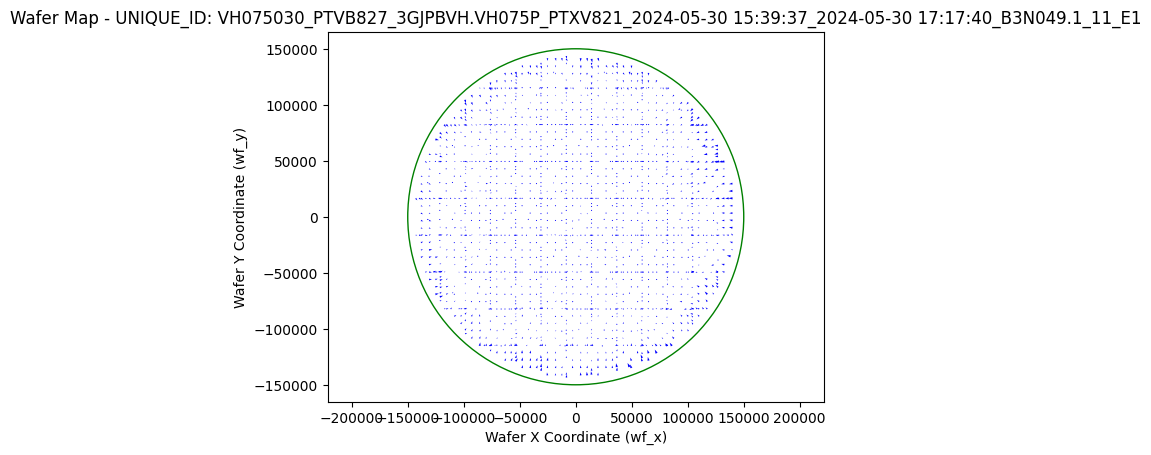

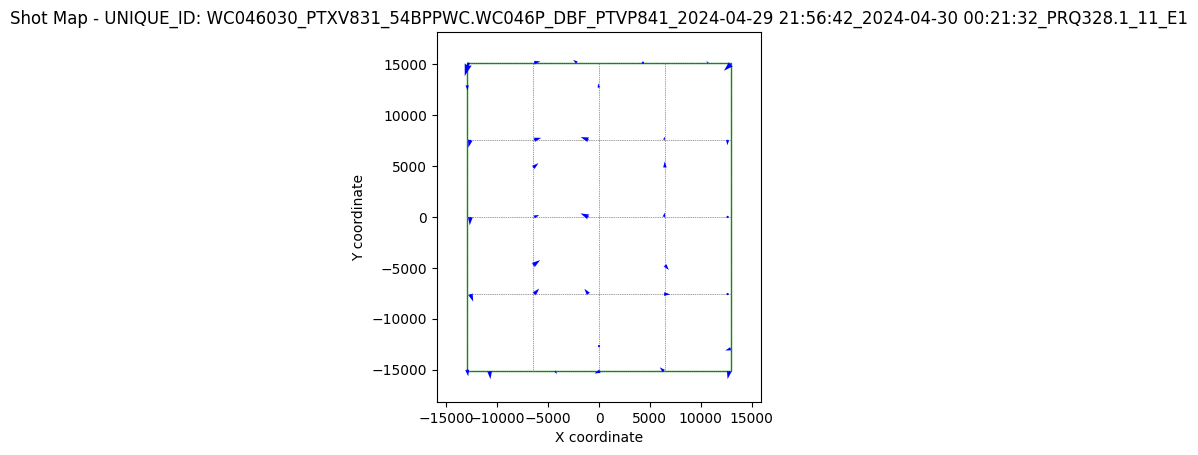

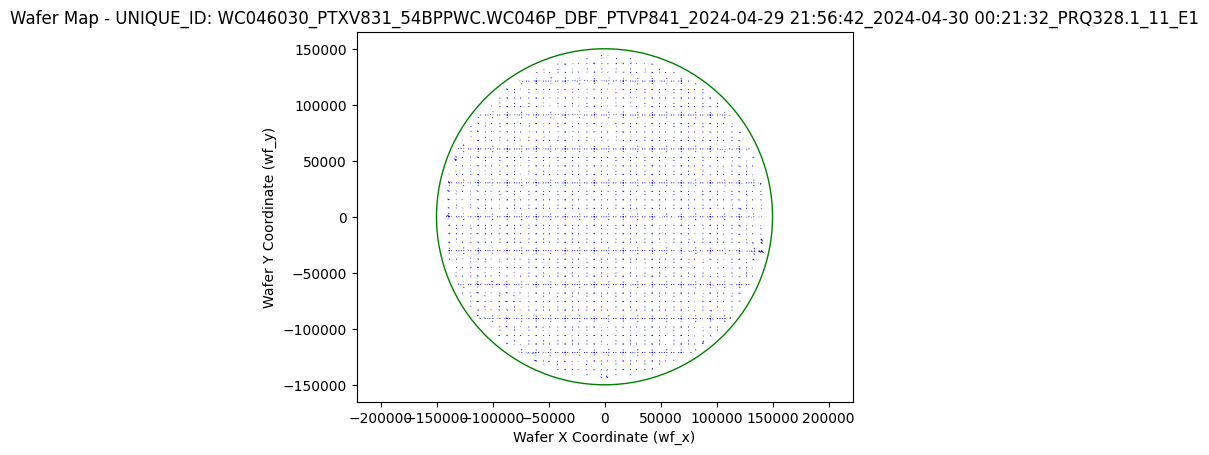

SystemExit: 0

c:\Python38\lib\site-packages\IPython\core\interactiveshell.py:3450: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [3]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PyQt5.QtWidgets import (QApplication, QMainWindow, QWidget, QVBoxLayout, QHBoxLayout,
                             QPushButton, QLabel, QFileDialog, QListWidget, QMessageBox)

class DataProcessor:
    def __init__(self, file_path):
        self.file_path = file_path
        self.wafer_radius = 150000
        self.df = None
        self.df_with_partial = None
        self.df_non_partial_avg = None
        self.df_ifu = None
        self.df_iwu = None
        self.df_with_detrended = None

    def compute_is_partial_shot(self):
        df = self.df
        wafer_radius = self.wafer_radius
        partial_shot_info = []

        # UNIQUE_ID별로 그룹화하여 STEP_PITCH 값을 사용
        for unique_id, group in df.groupby('UNIQUE_ID'):
            step_pitch_x_value = group['STEP_PITCH_X'].iloc[0]
            step_pitch_y_value = group['STEP_PITCH_Y'].iloc[0]
            
            for _, row in group.iterrows():
                dx, dy = row['DieX'], row['DieY']
                x, y = row['fcp_x'], row['fcp_y']
                
                bottom_left = (x - step_pitch_x_value / 2, y - step_pitch_y_value / 2)
                bottom_right = (x + step_pitch_x_value / 2, y - step_pitch_y_value / 2)
                top_left = (x - step_pitch_x_value / 2, y + step_pitch_y_value / 2)
                top_right = (x + step_pitch_x_value / 2, y + step_pitch_y_value / 2)
                
                corners = [bottom_left, bottom_right, top_left, top_right]
                distances = [np.sqrt(c[0]**2 + c[1]**2) for c in corners]
                
                is_partial = any(dist > wafer_radius for dist in distances)
                
                shot_info = {
                    "UNIQUE_ID": unique_id,
                    "DieX": dx, 
                    "DieY": dy,
                    "Is Partial Shot": is_partial,
                }
                
                partial_shot_info.append(shot_info)
        
        # partial_shot_info 리스트를 DataFrame으로 변환
        partial_shot_df = pd.DataFrame(partial_shot_info)
        
        
        # 기존 DataFrame과 Is Partial Shot 열을 병합
        df_merged = pd.concat([df, partial_shot_df['Is Partial Shot']], axis=1)

        self.df_with_partial = df_merged

    def compute_non_partial_averages(self):
        """
        Partial Shot이 아닌 데이터에 대해 X_reg와 Y_reg의 평균을 계산합니다.
        """
        df = self.df_with_partial

        # Partial Shot이 아닌 데이터만 필터링
        df_non_partial = df[df['Is Partial Shot'] == False]
        
        # UNIQUE_ID, TEST, coordinate_X, coordinate_Y별로 평균 계산
        df_non_partial_avg = df_non_partial.groupby(['UNIQUE_ID', 'TEST', 'coordinate_X', 'coordinate_Y']).agg({
            'X_reg': 'mean',
            'Y_reg': 'mean',
            'STEP_PITCH_X': 'first',
            'STEP_PITCH_Y': 'first',
            'CHIP_X_NUM': 'first',
            'CHIP_Y_NUM': 'first'
        }).reset_index()
        df_non_partial_avg.rename(columns={'X_reg': 'X_reg_avg', 'Y_reg': 'Y_reg_avg'}, inplace=True)
        self.df_non_partial_avg = df_non_partial_avg

    def compute_ifu(self):
        """
        각 UNIQUE_ID별로 IFU_x와 IFU_y를 계산합니다.
        """
        df_non_partial_avg = self.df_non_partial_avg
        ifu_values = []
        for unique_id, group in df_non_partial_avg.groupby('UNIQUE_ID'):
            mean_x = np.mean(group['X_reg_avg'])
            std_dev_x = np.std(group['X_reg_avg'])
            ifu_x = abs(mean_x) + (3 * std_dev_x)
            
            mean_y = np.mean(group['Y_reg_avg'])
            std_dev_y = np.std(group['Y_reg_avg'])
            ifu_y = abs(mean_y) + (3 * std_dev_y)
            
            ifu_values.append({'UNIQUE_ID': unique_id, 'ifu_x': ifu_x, 'ifu_y': ifu_y})
        df_ifu = pd.DataFrame(ifu_values)
        self.df_ifu = df_ifu

    def compute_iwu(self):
        """
        전체 데이터에서 IWU_x와 IWU_y를 계산합니다.
        """
        df = self.df_with_partial
        df_non_partial_avg = self.df_non_partial_avg
        # 전체 데이터에 non_partial에서 계산한 평균값을 병합
        df_merged = pd.merge(df, df_non_partial_avg[['UNIQUE_ID', 'TEST', 'coordinate_X', 'coordinate_Y', 'X_reg_avg', 'Y_reg_avg']], 
                             on=['UNIQUE_ID', 'TEST', 'coordinate_X', 'coordinate_Y'], how='left')
        
        # X_reg_detrended 및 Y_reg_detrended 계산
        df_merged['X_reg_detrended'] = df_merged['X_reg'] - df_merged['X_reg_avg']
        df_merged['Y_reg_detrended'] = df_merged['Y_reg'] - df_merged['Y_reg_avg']
        
        # UNIQUE_ID별로 IWU 계산
        iwu_values = []
        for unique_id, group in df_merged.groupby('UNIQUE_ID'):
            # IWU_x 계산
            mean_detrended_x = np.mean(group['X_reg_detrended'].dropna())
            std_dev_detrended_x = np.std(group['X_reg_detrended'].dropna())
            iwu_x = abs(mean_detrended_x) + (3 * std_dev_detrended_x)
            
            # IWU_y 계산
            mean_detrended_y = np.mean(group['Y_reg_detrended'].dropna())
            std_dev_detrended_y = np.std(group['Y_reg_detrended'].dropna())
            iwu_y = abs(mean_detrended_y) + (3 * std_dev_detrended_y)
            
            iwu_values.append({'UNIQUE_ID': unique_id, 'iwu_x': iwu_x, 'iwu_y': iwu_y})
        df_iwu = pd.DataFrame(iwu_values)
        self.df_iwu = df_iwu
        self.df_with_detrended = df_merged

    def process_data(self):
        # 데이터 불러오기
        self.df = pd.read_csv(self.file_path)

        # 데이터 처리
        self.compute_is_partial_shot()
        self.compute_non_partial_averages()
        self.compute_ifu()
        self.compute_iwu()

        # 결과 저장
        self.save_results()

    def save_results(self):
        # 결과 저장
        self.df_with_partial.to_csv('df_with_partial.csv', index=False)
        self.df_non_partial_avg.to_csv('df_non_partial_avg.csv', index=False)
        self.df_ifu.to_csv('ifu_results.csv', index=False)
        self.df_iwu.to_csv('iwu_results.csv', index=False)
        self.df_with_detrended.to_csv('df_with_detrended.csv', index=False)
        print("결과 데이터가 CSV 파일로 저장되었습니다.")

def plot_shot_map(df_avg, unique_id):
    """
    지정된 UNIQUE_ID에 대한 샷 맵을 그립니다.
    """
    df_subset = df_avg[df_avg['UNIQUE_ID'] == unique_id]
    if df_subset.empty:
        print(f"UNIQUE_ID {unique_id}에 대한 데이터가 없습니다.")
        return
    
    # 데이터 값들
    step_pitch_x = df_subset['STEP_PITCH_X'].iloc[0]
    step_pitch_y = df_subset['STEP_PITCH_Y'].iloc[0]
    chip_x_num = int(df_subset['CHIP_X_NUM'].iloc[0])
    chip_y_num = int(df_subset['CHIP_Y_NUM'].iloc[0])

    # shot의 중심 좌표
    shot_center_x = 0
    shot_center_y = 0

    # shot의 모서리 좌표 계산
    shot_left = shot_center_x - step_pitch_x / 2
    shot_bottom = shot_center_y - step_pitch_y / 2

    # chip의 크기 계산
    chip_width = step_pitch_x / chip_x_num
    chip_height = step_pitch_y / chip_y_num

    # 그림 그리기
    fig, ax = plt.subplots()

    # shot 사각형 그리기
    shot_rect = patches.Rectangle((shot_left, shot_bottom), step_pitch_x, step_pitch_y,
                                  linewidth=1, edgecolor='green', facecolor='none')
    ax.add_patch(shot_rect)

    # chip 경계선 점선으로 추가
    for i in range(chip_x_num):
        for j in range(chip_y_num):
            chip_left = shot_left + i * chip_width
            chip_bottom = shot_bottom + j * chip_height
            chip_rect = patches.Rectangle((chip_left, chip_bottom), chip_width, chip_height,
                                          linewidth=0.5, edgecolor='grey', linestyle='dotted', facecolor='none')
            ax.add_patch(chip_rect)

    # 평균 overlay 벡터 표시
    ax.quiver(df_subset['coordinate_X'], df_subset['coordinate_Y'], 
              df_subset['X_reg_avg'], df_subset['Y_reg_avg'], 
              angles='xy', scale_units='xy', scale=1e-6, color='blue')

    # 그래프 설정
    ax.set_xlim(shot_left - 3000, shot_left + step_pitch_x + 3000)
    ax.set_ylim(shot_bottom - 3000, shot_bottom + step_pitch_y + 3000)
    ax.set_aspect('equal')
    ax.set_xlabel('X coordinate')
    ax.set_ylabel('Y coordinate')
    ax.set_title(f'Shot Map - UNIQUE_ID: {unique_id}')

    # 플롯 보여주기
    plt.show()

def plot_wafer_map(df, unique_id):
    """
    지정된 UNIQUE_ID에 대한 웨이퍼 맵을 그립니다.
    """
    df_subset = df[df['UNIQUE_ID'] == unique_id]
    if df_subset.empty:
        print(f"UNIQUE_ID {unique_id}에 대한 데이터가 없습니다.")
        return
    
    x = df_subset['wf_x']
    y = df_subset['wf_y']
    dx = df_subset['X_reg_detrended']
    dy = df_subset['Y_reg_detrended']

    # 그림 그리기
    fig, ax = plt.subplots()

    # Overlay 벡터 표시
    ax.quiver(x, y, dx, dy, angles='xy', scale_units='xy', scale=1e-6, color='blue')

    # 웨이퍼 경계선 추가
    wafer_radius = 150000
    wafer_circle = patches.Circle((0, 0), wafer_radius, color='green', fill=False)
    ax.add_patch(wafer_circle)

    # 그래프 설정
    ax.set_xlabel('Wafer X Coordinate (wf_x)')
    ax.set_ylabel('Wafer Y Coordinate (wf_y)')
    ax.set_title(f'Wafer Map - UNIQUE_ID: {unique_id}')
    ax.axis('equal')

    # 플롯 보여주기
    plt.show()

class VisualizationApp(QMainWindow):
    def __init__(self):
        super().__init__()
        self.setWindowTitle("Data Visualization App")
        self.setGeometry(100, 100, 600, 400)

        self.data_processor = None

        # 위젯 설정
        self.load_button = QPushButton("파일 열기")
        self.load_button.clicked.connect(self.load_file)

        self.unique_id_list = QListWidget()

        self.visualize_button = QPushButton("시각화 실행")
        self.visualize_button.clicked.connect(self.visualize)

        layout = QVBoxLayout()
        layout.addWidget(self.load_button)
        layout.addWidget(QLabel("UNIQUE_ID 목록"))
        layout.addWidget(self.unique_id_list)
        layout.addWidget(self.visualize_button)

        container = QWidget()
        container.setLayout(layout)
        self.setCentralWidget(container)

    def load_file(self):
        file_path, _ = QFileDialog.getOpenFileName(self, "CSV 파일 선택", "", "CSV Files (*.csv)")
        if file_path:
            self.data_processor = DataProcessor(file_path)
            self.data_processor.process_data()
            self.populate_unique_id_list()
            QMessageBox.information(self, "완료", "데이터 처리가 완료되었습니다.")
        else:
            QMessageBox.warning(self, "경고", "파일을 선택하지 않았습니다.")

    def populate_unique_id_list(self):
        if self.data_processor:
            unique_ids = self.data_processor.df_with_partial['UNIQUE_ID'].unique()
            self.unique_id_list.clear()
            self.unique_id_list.addItems(unique_ids.astype(str))

    def visualize(self):
        selected_items = self.unique_id_list.selectedItems()
        if not selected_items:
            QMessageBox.warning(self, "경고", "UNIQUE_ID를 선택하세요.")
            return
        unique_id = selected_items[0].text()
        plot_shot_map(self.data_processor.df_non_partial_avg, unique_id)
        plot_wafer_map(self.data_processor.df_with_detrended, unique_id)

def main():
    app = QApplication(sys.argv)
    window = VisualizationApp()
    window.show()
    sys.exit(app.exec_())

if __name__ == "__main__":
    main()
